In [1]:
import numpy as np
import cv2 as cv
import os
import time

In [2]:
yolo_dir = './' # YOLO文件路径 
weightsPath = os.path.join(yolo_dir, 'yolov3.weights') # 权重文件 
configPath = os.path.join(yolo_dir, 'yolov3.cfg') # 配置文件 
labelsPath = os.path.join(yolo_dir, 'coco.names') # label名称 
imgPath = os.path.join(yolo_dir, 'test.jpg') # 测试图像 
CONFIDENCE = 0.5 # 过滤弱检测的最小概率 
THRESHOLD = 0.4 # 非最大值抑制阈值


In [3]:
# 加载网络、配置权重 
net = cv.dnn.readNetFromDarknet(configPath, weightsPath) ## 利用下载的文件 
print("[INFO] loading YOLO from disk...") ## 可以打印下信息 

# 加载图片、转为blob格式、送入网络输入层 
## net需要的输入是blob格式的，用blobFromImage这个函数来转格式 
img = cv.imread(imgPath) 
blobImg = cv.dnn.blobFromImage(img, 1.0/255.0, (416, 416), None, True, False) 
net.setInput(blobImg) ## 调用setInput函数将图片送入输入层 

# 获取网络输出层信息（所有输出层的名字），设定并前向传播 
## yolov3在每个scale都有输出，outInfo是每个scale的名字信息，供net.forward使用
outInfo = net.getUnconnectedOutLayersNames()
start = time.time() 
layerOutputs = net.forward(outInfo) # 得到各个输出层的、各个检测框等信息，是二维结构。 
end = time.time() 
print("[INFO] YOLO took {:.6f} seconds".format(end - start)) ## 可以打印下信息


[INFO] loading YOLO from disk...
[INFO] YOLO took 0.797542 seconds


In [6]:
def detect(img_file):
    img = cv.imread(img_file + ".jpg") 
    # 加载图片、转为blob格式、送入网络输入层 
    # net需要的输入是blob格式的，用blobFromImage这个函数来转格式 
    blobImg = cv.dnn.blobFromImage(img, 1.0/255.0, (416, 416), None, True, False) 
    net.setInput(blobImg) ## 调用setInput函数将图片送入输入层 
    
    outInfo = net.getUnconnectedOutLayersNames()
    start = time.time() 
    layerOutputs = net.forward(outInfo) # 得到各个输出层的、各个检测框等信息，是二维结构。 
    
    (H, W) = img.shape[:2]	# 拿到图片尺寸
    # 过滤layerOutputs，layerOutputs的第1维的元素内容: [center_x, center_y, width, height, objectness, N-class score data]，过滤后的结果放入：
    boxes = [] # 所有边界框（各层结果放一起）
    confidences = [] # 所有置信度
    classIDs = [] # 所有分类ID
    # # 1）过滤掉置信度低的检测框
    for out in layerOutputs:  # 各个输出层
        for detection in out:  # 各个检测框
            scores = detection[5:]  # 拿到各个类别的置信度
            classID = np.argmax(scores)  # 最高置信度的id即为分类id
            confidence = scores[classID]  # 拿到置信度
            if confidence > CONFIDENCE:   # 根据置信度筛查
                box = detection[0:4] * np.array([W, H, W, H])  # 将边界框放会图片尺寸
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # # 2）应用非最大值抑制(non-maxima suppression，nms)进一步筛掉，这里使用NMS算法。
    idxs = cv.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD) # boxes中，保留的box的索引index存入idxs
    # 得到labels列表
    with open(labelsPath, 'rt') as f:
        labels = f.read().rstrip('\n').split('\n')
    # 应用检测结果
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")  
    # 框框显示颜色，每一类有不同的颜色，每种颜色都是由RGB三个值组成的，所以size为(len(labels), 3)
    if len(idxs) > 0:
        for i in idxs.flatten():  # indxs是二维的，第0维是输出层，所以这里把它展平成1维
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv.rectangle(img, (x, y), (x+w, y+h), color, 7)  # 线条粗细为2px
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            # cv.FONT_HERSHEY_SIMPLEX字体风格、0.5字体大小、粗细2px
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 2.5, color, 6)  
    cv.imwrite(img_file + "_detected.jpg", img)

In [5]:
import matplotlib.pyplot as plt
def compared(img):
    pic = img + ".jpg"
    ori_pic = cv.imread(img + ".jpg",-1)
    height, width = ori_pic.shape[:2] # 第0、第1项
    plt.figure(figsize=(21,21))
    
    plt.subplot(1,2,1), plt.title('Original')
    tmp1 = cv.imread(img + ".jpg",-1)
    type(tmp1)
    tmp1.shape
    plt.imshow(np.flip(tmp1, axis = 2)),plt.axis('off')
    
    plt.subplot(1,2,2),plt.title('Detected')
    tmp2 = cv.imread(img + "_detected.jpg", -1)
    type(tmp2)
    tmp2.shape
    plt.imshow(np.flip(tmp2, axis = 2)),plt.axis('off')
    
    plt.show()

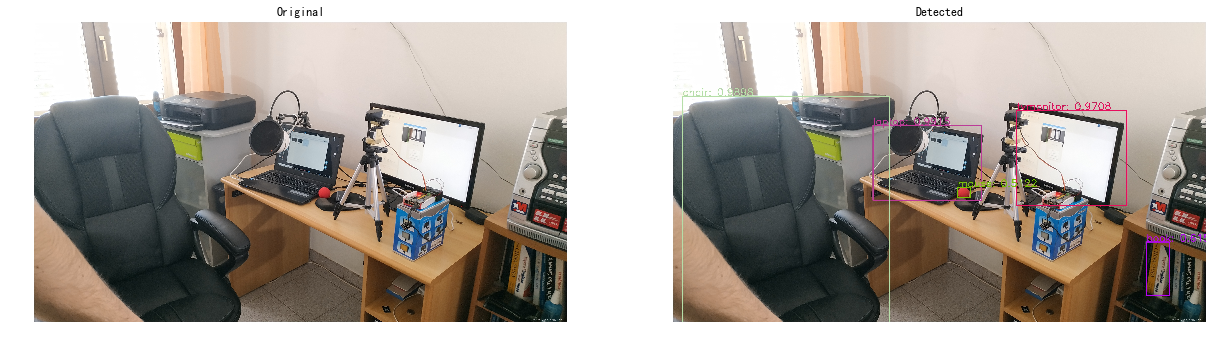

In [7]:
detect_img = "test"
detect(detect_img)
compared(detect_img)

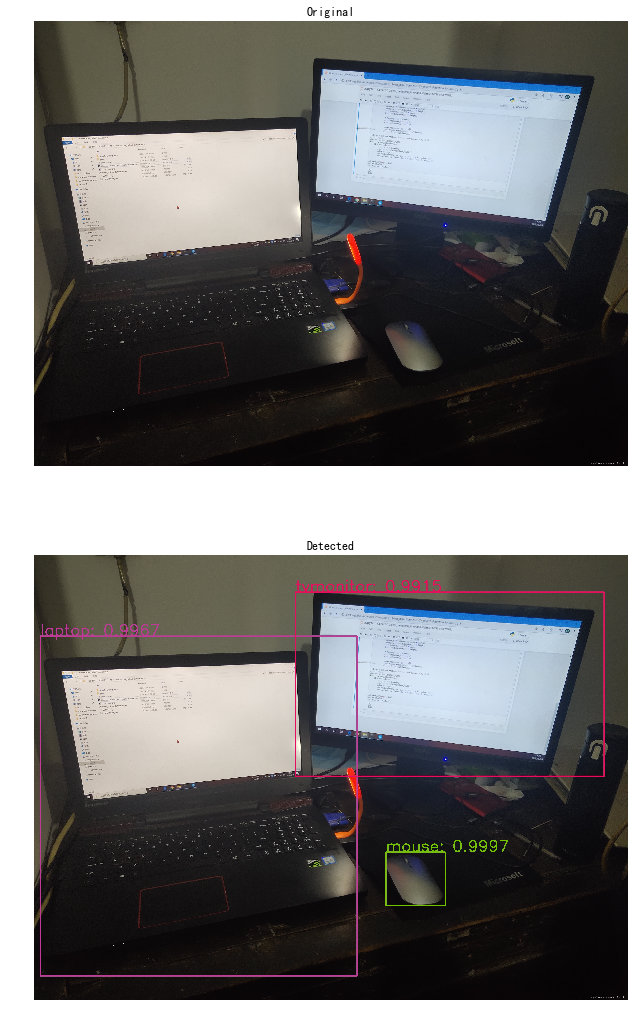

In [33]:
detect_img = "test2"
detect(detect_img)
compared(detect_img)

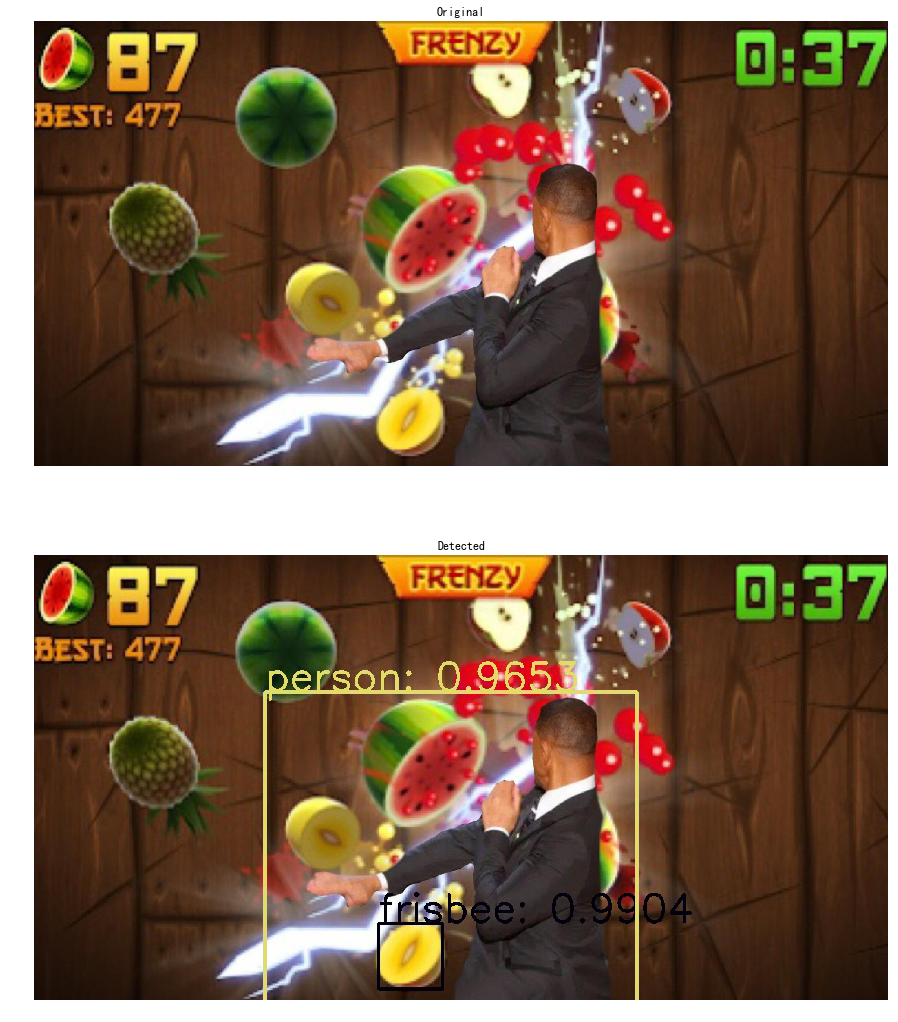

In [36]:
detect_img = "test4"
detect(detect_img)
compared(detect_img)

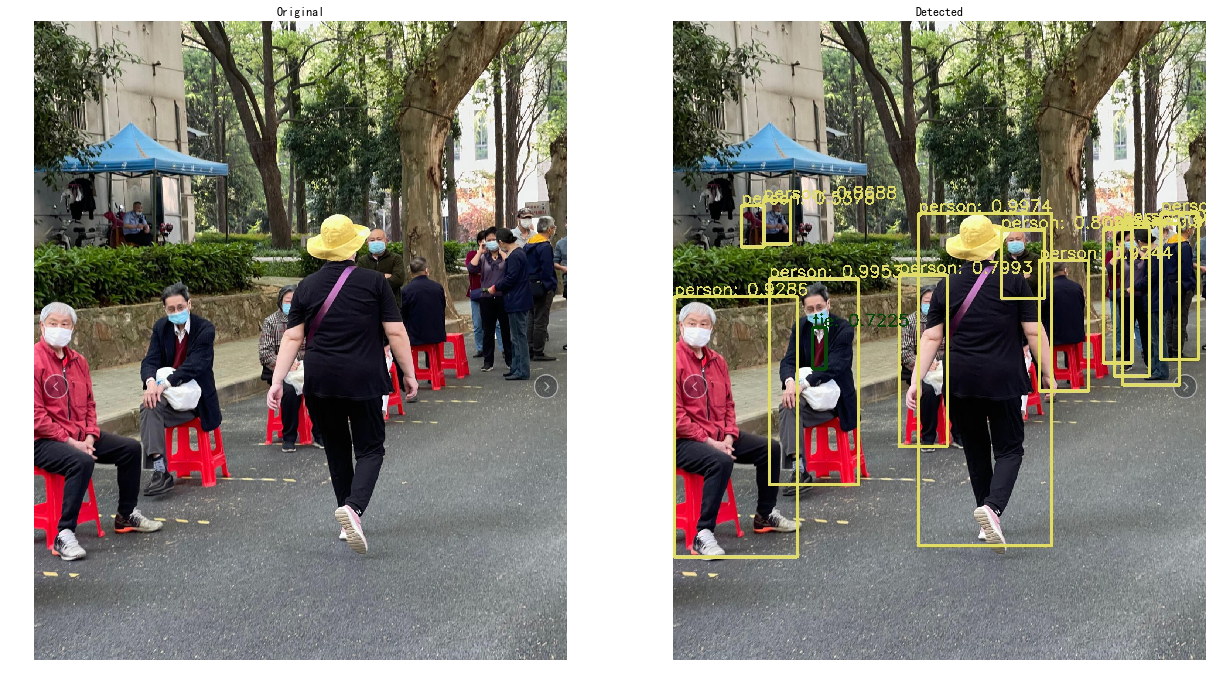

In [44]:
detect_img = "test5"
detect(detect_img)
compared(detect_img)

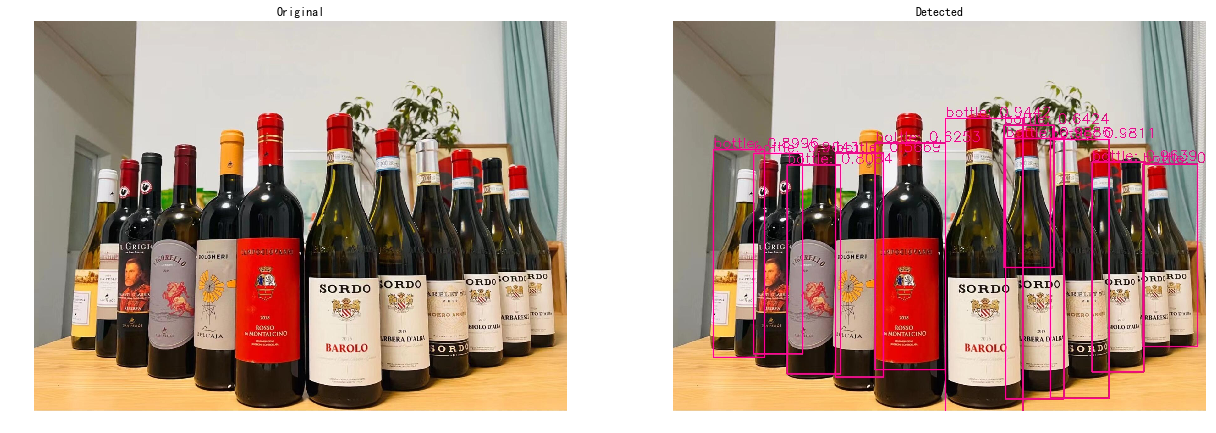

In [55]:
detect_img = "test6"
detect(detect_img)
compared(detect_img)